### Concept Of LLM suggestion
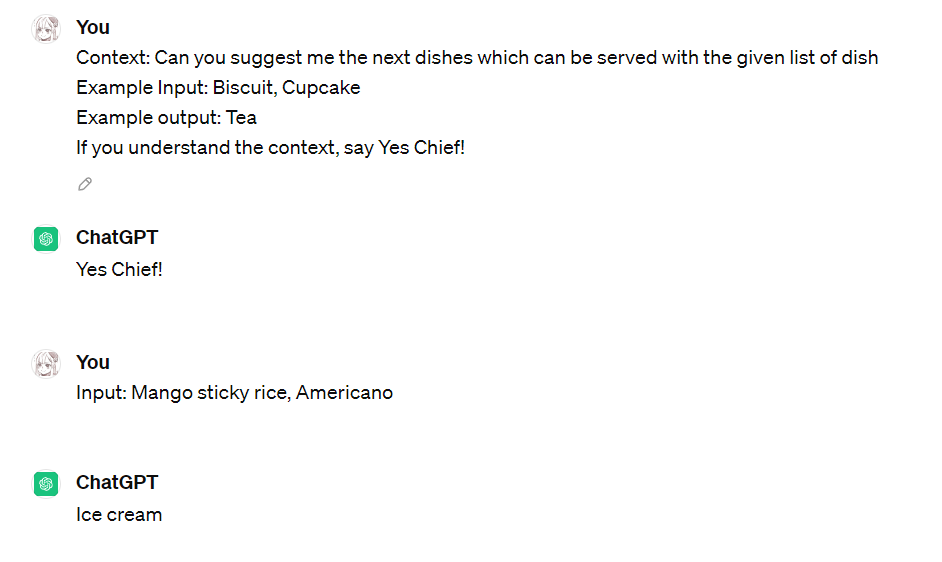